In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import tqdm
import glob
import urllib.request
%matplotlib inline



In [2]:
df = pd.read_csv('data.csv', header=None, names=["id", "image", "published", "disabled"])

df['available'] = 0

all_images_path = 'data/all_images'

for i, row in df.iterrows():
    file = os.path.join(all_images_path, row['id'] + '.jpg')
    if os.path.isfile(file):
        df.at[i, 'available'] = 1

        
df = df.loc[df.query('available == 1').index, :]
df = df.reset_index(drop=True)
df

,id,image,published,disabled,available
0,5e5836fee917e8d9a8a7b277,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
1,5e58343ded065ad79e312f3d,https://scontent.xx.fbcdn.net/v/t51.2885-15/85...,1,0,1
2,5e57dc939e88b6be2ac42800,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
3,5e55dca437fa5927dcdf02f3,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,1,0,1
4,5e55d69eb9e5b725cd7ba02f,https://scontent.xx.fbcdn.net/v/t51.2885-15/87...,1,0,1
...,...,...,...,...,...
8314,5e253779f1b8d48ba5de7d32,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
8315,5e252d334610948976f731e5,https://scontent.xx.fbcdn.net/v/t51.2885-15/81...,0,1,1
8316,5e252d334610948976f731e6,https://scontent.xx.fbcdn.net/v/t51.2885-15/83...,0,1,1
8317,5e252d3342307c89757703c0,https://scontent.xx.fbcdn.net/v/t51.2885-15/82...,0,1,1


In [3]:
import torchvision
import torch
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
import pickle
%matplotlib inline


image_map_numpy = {}

model = torchvision.models.resnet50(pretrained=True)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])


feature_extraction_model = torch.nn.Sequential(*list(model.children())[:-1])

feature_extraction_model.eval()


image_map_file = 'image_map_small.pkl'

with open(image_map_file, 'rb') as handle:
    image_map_numpy = pickle.load(handle)


In [6]:
print(image_map_numpy['5e5836fee917e8d9a8a7b277'].shape)
image_map_numpy['5e5836fee917e8d9a8a7b277']


(2048,)


array([0.06972015, 0.11041936, 0.38075703, ..., 0.5695779 , 0.3578882 ,
       0.22231062], dtype=float32)

In [7]:
from scipy.spatial.distance import cosine

img_repr_df = pd.DataFrame(image_map_numpy.items(), columns=['img_id', 'img_repr'])


def download_image(url, file='find.jpg'):
    with urllib.request.urlopen(url, timeout=5) as response:
        f = open(file, 'wb')
        f.write(response.read())
        f.close()
        
    return file
    
def get_similar_images(img, num_of_images=20):
    img = transformer(img)    
    base_vector = feature_extraction_model(img.unsqueeze(0))        
    base_vector = base_vector.squeeze().detach().numpy()

    cosine_similarity = 1 - img_repr_df['img_repr'].apply(lambda x: cosine(x, base_vector))

    similarity_ids = np.argsort(cosine_similarity)[-num_of_images:][::-1]

    return img_repr_df.iloc[similarity_ids]


def show_similar_images(similar_images_df):
    fig = plt.figure(figsize=(20, 20))
    cols = 4
    num_of_images = len(similar_images_df)
    
    i = 0
    for _, row in similar_images_df.iterrows():
        _id = row['img_id']
        ax = fig.add_subplot(num_of_images//cols+1, cols, i+1, xticks=[], yticks=[])
        file = os.path.join('data/all_images', _id + '.jpg')
        img = mpimg.imread(file)
        plt.imshow(img)
        i += 1

        

In [19]:
img_file = download_image('https://www.instagram.com/p/B40vbRIpugy/media?size=l')

(1146, 1080, 3)


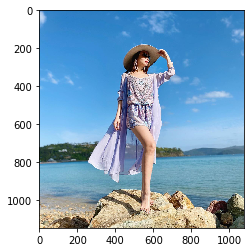

In [21]:
img = mpimg.imread(img_file)

print(img.shape)
#img = img[250:500, 100:300, :]
plt.imshow(img)

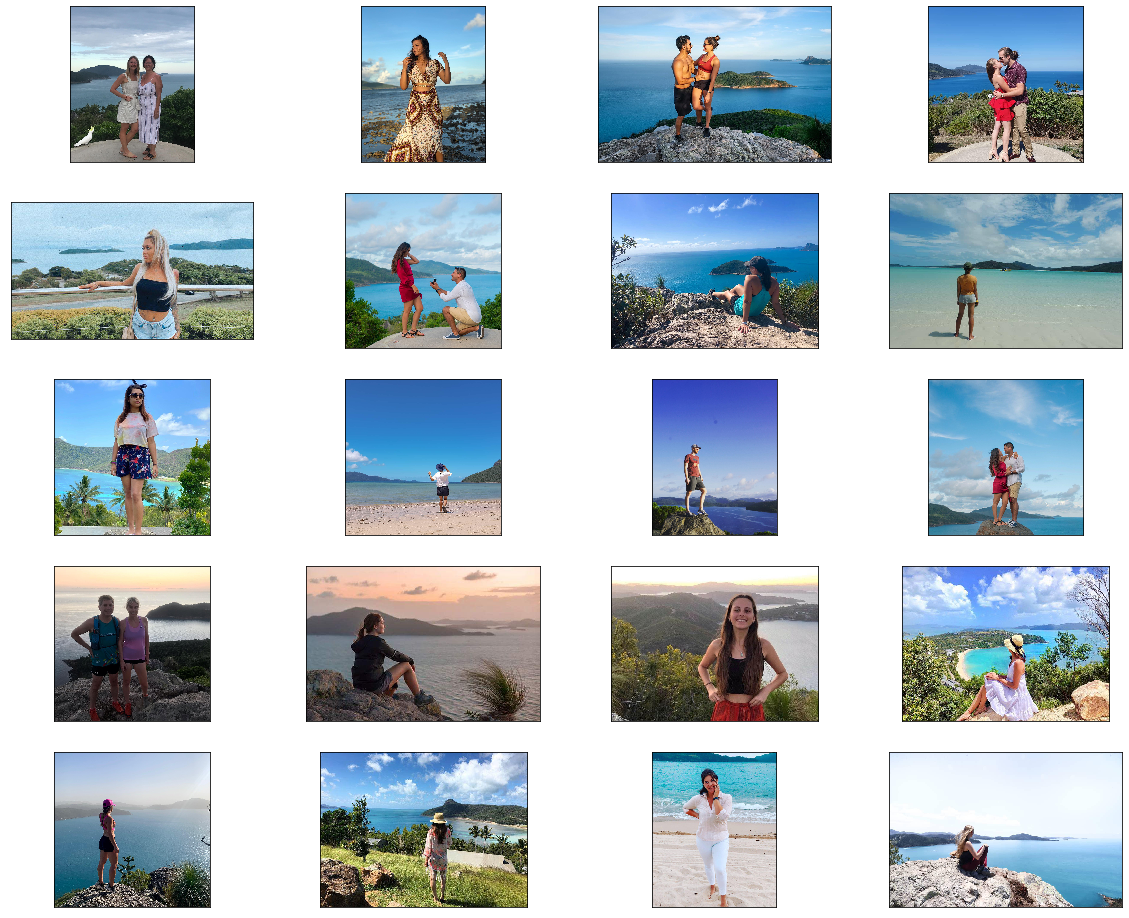

In [22]:
similar_images_df = get_similar_images(img, 20)        
show_similar_images(similar_images_df)
